In [21]:
import numpy as np
import yfinance as yf
from math import factorial
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# --- Signature core --------------------------------------------------------

def tensor_power(v, k):
    if k == 0:
        return np.array([1.], dtype=float)
    res = v.copy()
    for _ in range(k - 1):
        res = np.kron(res, v)
    return res

def segment_signature(v, depth):
    return [tensor_power(v, k) / factorial(k) for k in range(depth + 1)]

def concat_signatures(sigA, sigB):
    m = len(sigA) - 1
    new = []
    for k in range(m + 1):
        parts = []
        for i in range(k + 1):
            parts.append(np.kron(sigA[i], sigB[k - i]))
        new.append(sum(parts))
    return new

def path_signature(path, depth):
    path = np.asarray(path)
    n, d = path.shape
    sig_levels = [np.array([1.])] + [np.zeros(d ** k) for k in range(1, depth + 1)]
    for i in range(1, n):
        v = path[i] - path[i - 1]
        seg_sig = segment_signature(v, depth)
        sig_levels = concat_signatures(sig_levels, seg_sig)
    flat = np.concatenate([sig_levels[k] for k in range(1, depth + 1)])
    return flat, sig_levels

# --- Embeddings ------------------------------------------------------------

def lead_lag(series):
    """
    Lead-lag transform for 1D numeric input.
    Works safely even if series is a pandas column or has nested array values.
    Returns: (2n-1, 2) NumPy array
    """
    x = np.asarray(series).astype(float).reshape(-1)  # ensure flat 1D
    n = len(x)
    path = np.zeros((2 * n - 1, 2), dtype=float)

    for i in range(n):
        xi = float(x[i])  # guarantee scalar
        x_prev = float(x[i - 1]) if i > 0 else xi
        path[2 * i, 0] = xi
        path[2 * i, 1] = x_prev
        if 2 * i + 1 < 2 * n - 1:
            path[2 * i + 1, 0] = xi
            path[2 * i + 1, 1] = xi
    return path

def time_join(series, times=None):
    x = np.asarray(series)
    n = len(x)
    t = np.arange(n) if times is None else np.asarray(times)
    return np.stack([t, x], axis=1).astype(float)

# --- Feature pipeline ------------------------------------------------------

def build_signature_features(series, window, depth, embedding='leadlag', use_log=True):
    s = np.log(series) if use_log else np.asarray(series)
    n = len(s)
    X, y = [], []
    for end in range(window - 1, n - 1):
        seg = s[end - window + 1:end + 1]
        if embedding == 'leadlag':
            path = lead_lag(seg)
        else:
            t = np.arange(len(seg))
            path = time_join(seg, t)
        feat, _ = path_signature(path, depth)
        X.append(feat)
        y.append(s[end + 1] - s[end])
    return np.vstack(X), np.array(y)

In [22]:


# --- Example run -----------------------------------------------------------

ticker = "AAPL"
data = yf.download(ticker, start="2018-01-01", end="2025-11-01", auto_adjust=False)
close = data["Close"].values

window = 16
depth = 3
X, y = build_signature_features(close, window, depth)


print("Feature matrix:", X.shape, "Target:", y.shape)

tscv = TimeSeriesSplit(n_splits=5)
mses, r2s = [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mses.append(mean_squared_error(y_test, pred))
    r2s.append(r2_score(y_test, pred))

print("Avg MSE:", np.mean(mses))
print("Avg R2:", np.mean(r2s))


[*********************100%***********************]  1 of 1 completed


Feature matrix: (1954, 14) Target: (1954, 1)
Avg MSE: 0.0003905795127907392
Avg R2: -0.004923841793095862


Feature matrix: (1954, 14)


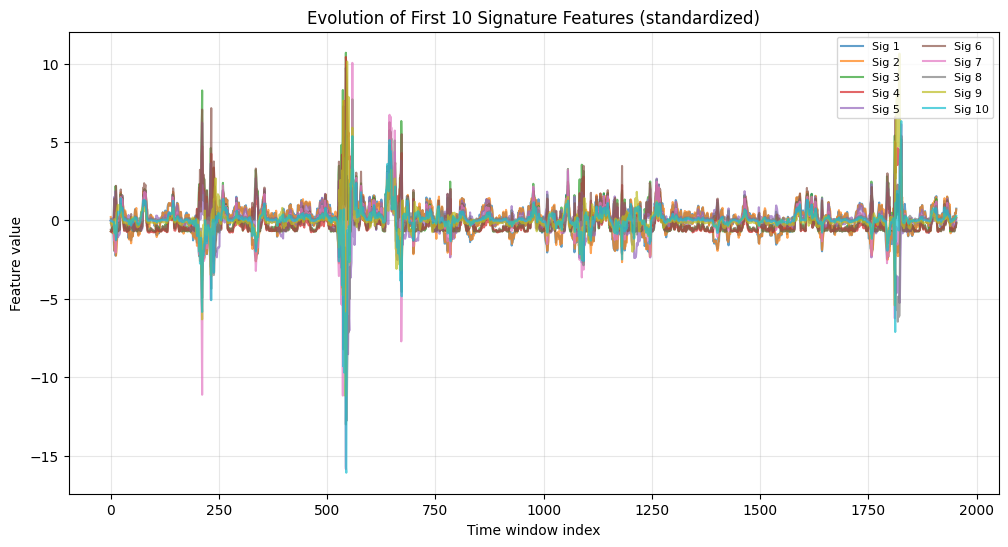

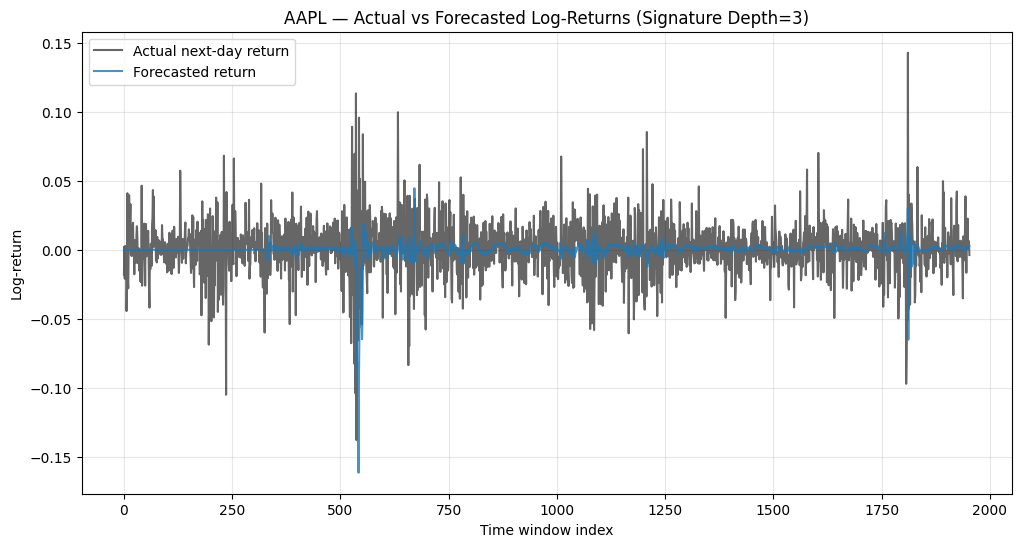

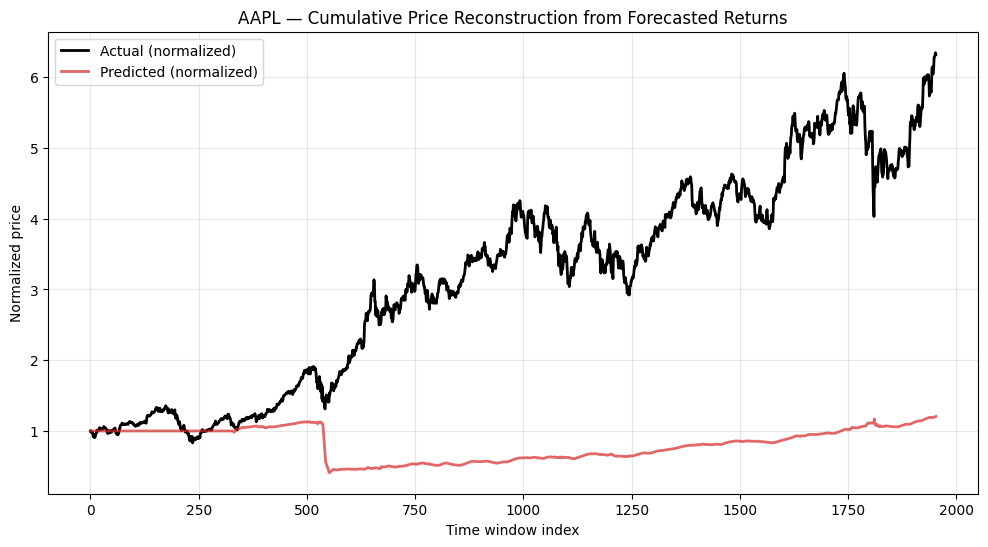

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ===============================================================
# 1️⃣ Compute Signature Features (already done)
# ===============================================================
window = 16
depth = 3
X, y = build_signature_features(close, window, depth)

# Standardize the features (helps regression & visualization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix:", X_scaled.shape)

# ===============================================================
# 2️⃣ Visualize Signature Feature Evolution
# ===============================================================
plt.figure(figsize=(12, 6))
plt.title("Evolution of First 10 Signature Features (standardized)")
for i in range(min(10, X_scaled.shape[1])):
    plt.plot(X_scaled[:, i], label=f"Sig {i+1}", alpha=0.7)
plt.xlabel("Time window index")
plt.ylabel("Feature value")
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

# ===============================================================
# 3️⃣ Train Ridge Model and Forecast Next-Day Returns
# ===============================================================
tscv = TimeSeriesSplit(n_splits=5)
pred_full = np.zeros(y.shape[0], dtype=float)  # ensure 1D

model = Ridge(alpha=1.0)

for train_idx, test_idx in tscv.split(X_scaled):
    model.fit(X_scaled[train_idx], y[train_idx])
    pred = model.predict(X_scaled[test_idx]).reshape(-1)  # flatten just in case
    pred_full[test_idx] = pred


# ===============================================================
# 4️⃣ Visualize Actual vs Forecasted Returns
# ===============================================================
plt.figure(figsize=(12, 6))
plt.title(f"{ticker} — Actual vs Forecasted Log-Returns (Signature Depth={depth})")
plt.plot(y, label="Actual next-day return", color="black", alpha=0.6)
plt.plot(pred_full, label="Forecasted return", color="tab:blue", alpha=0.8)
plt.xlabel("Time window index")
plt.ylabel("Log-return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ===============================================================
# 5️⃣ Cumulative Forecasted vs Actual Prices (optional)
# ===============================================================
# Reconstruct cumulative price path from returns
price_true = np.exp(np.cumsum(y))
price_pred = np.exp(np.cumsum(pred_full))

plt.figure(figsize=(12, 6))
plt.title(f"{ticker} — Cumulative Price Reconstruction from Forecasted Returns")
plt.plot(price_true / price_true[0], label="Actual (normalized)", color="black", lw=2)
plt.plot(price_pred / price_pred[0], label="Predicted (normalized)", color="tab:red", lw=2, alpha=0.7)
plt.xlabel("Time window index")
plt.ylabel("Normalized price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
